<a href="https://colab.research.google.com/github/oreilly-japan/ml-at-work/blob/master/chap11/03_contextual_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-947-2.gif)

이 노트북은 한빛미디어에서 발생한 [<<머신러닝 실무 프로젝트 2판>>]()의 샘플 코드입니다. 코드 설명은 책 내용을 확인합니다. 또한, 이 코드를 실행한 결과에 대해 한빛미디어 및 옮긴이는 일체의 책임을 지지 않습니다.

## 11.8 컨텍스트 기반 슬롯머신 부트스트랩 구현

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
class BootstrapTSContextualBandit:
    def __init__(self, regression_model_cls, param, arm_num=2, model_num=100, seed=None, bagging_rate=1.0):
        self.arm_num = arm_num
        self.model_num = model_num
        self.bagging_rate = bagging_rate
        self.seed = seed
        self.models = [
            [
                regression_model_cls(**param)
                for i in range(model_num)
            ]
            for j in range(self.arm_num)            
        ]
        self.is_initialized = False
            
    def fit(self, x, arm, y):
        np.random.seed(self.seed)

        for arm_id in range(self.arm_num):
            _x = x[arm == arm_id]
            _y = y[arm == arm_id]
            n_samples = len(_y)

            for i in range(self.model_num):
                picked_sample = np.random.randint(0, n_samples, int(n_samples * self.bagging_rate)) 
                bootstrap_weight = np.bincount(picked_sample, minlength=n_samples)
                self.models[arm_id][i].fit(_x, _y, sample_weight=bootstrap_weight)

        self.is_initialized = True

    def _predict_mean_sd(self, x, arm_id):
        predict_result = np.array([
            estimator.predict(x)
            for estimator in self.models[arm_id]
        ])

        mean = np.mean(predict_result, axis=0)
        sd = np.std(predict_result, axis=0)

        return mean, sd
    
    def _predict_thompson_sampling(self, x, arm_id):
        mean, sd = self._predict_mean_sd(x, arm_id)
        return np.random.normal(mean, sd)
        
    def choice_arm(self, x):
        if self.is_initialized is False:
            return np.random.choice(self.arm_num, x.shape[0])

        score_list = np.zeros((x.shape[0], self.arm_num), dtype=np.float64)
        for arm_id in range(self.arm_num):
            score_list[:, arm_id] = self._predict_thompson_sampling(x, arm_id)
        return np.argmax(score_list, axis=1)

In [3]:
def generate_sample_data(sample_num=10000):
    weight = np.array([
        [0.05, 0.05, -0.05, 0.0, 0.0, 0.0, 0.0],
        [-0.05, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0],
        [0.05, -0.05, 0.05, 0.0, 0.0, 0.0, 0.0],
    ])

    arm_num, feature_num = weight.shape
    feature_vector = np.random.rand(sample_num, feature_num)

    theta = np.zeros((sample_num, arm_num))
    for i in range(arm_num):
        theta[:,i] = np.sum(feature_vector * weight[i], axis = 1)
        
    is_cv = (theta > np.random.rand(sample_num, arm_num)).astype(np.int8)

    return feature_vector, is_cv

In [4]:
import sklearn.tree

loop_num = 100
batch_size = 1000

base_model = sklearn.tree.DecisionTreeRegressor
param = {
        'max_depth': 6,
        'min_samples_split': 10,
        'max_features': None,
}

model = BootstrapTSContextualBandit(base_model, param, arm_num = 3)

x_history = np.zeros((0, 7))
y_history = np.zeros(0)
arm_history = np.zeros(0)
scores = []

for i in range(loop_num):
    x, is_cv = generate_sample_data(batch_size)

    choiced_arm = model.choice_arm(x)
    y = is_cv[range(batch_size), choiced_arm]
   
    x_history = np.vstack((x_history, x))
    y_history = np.append(y_history, y)
    arm_history = np.append(arm_history, choiced_arm)
    
    model.fit(x_history, arm_history, y_history)
    
    score = np.sum(y_history) / y_history.shape[0]
    scores.append(score)

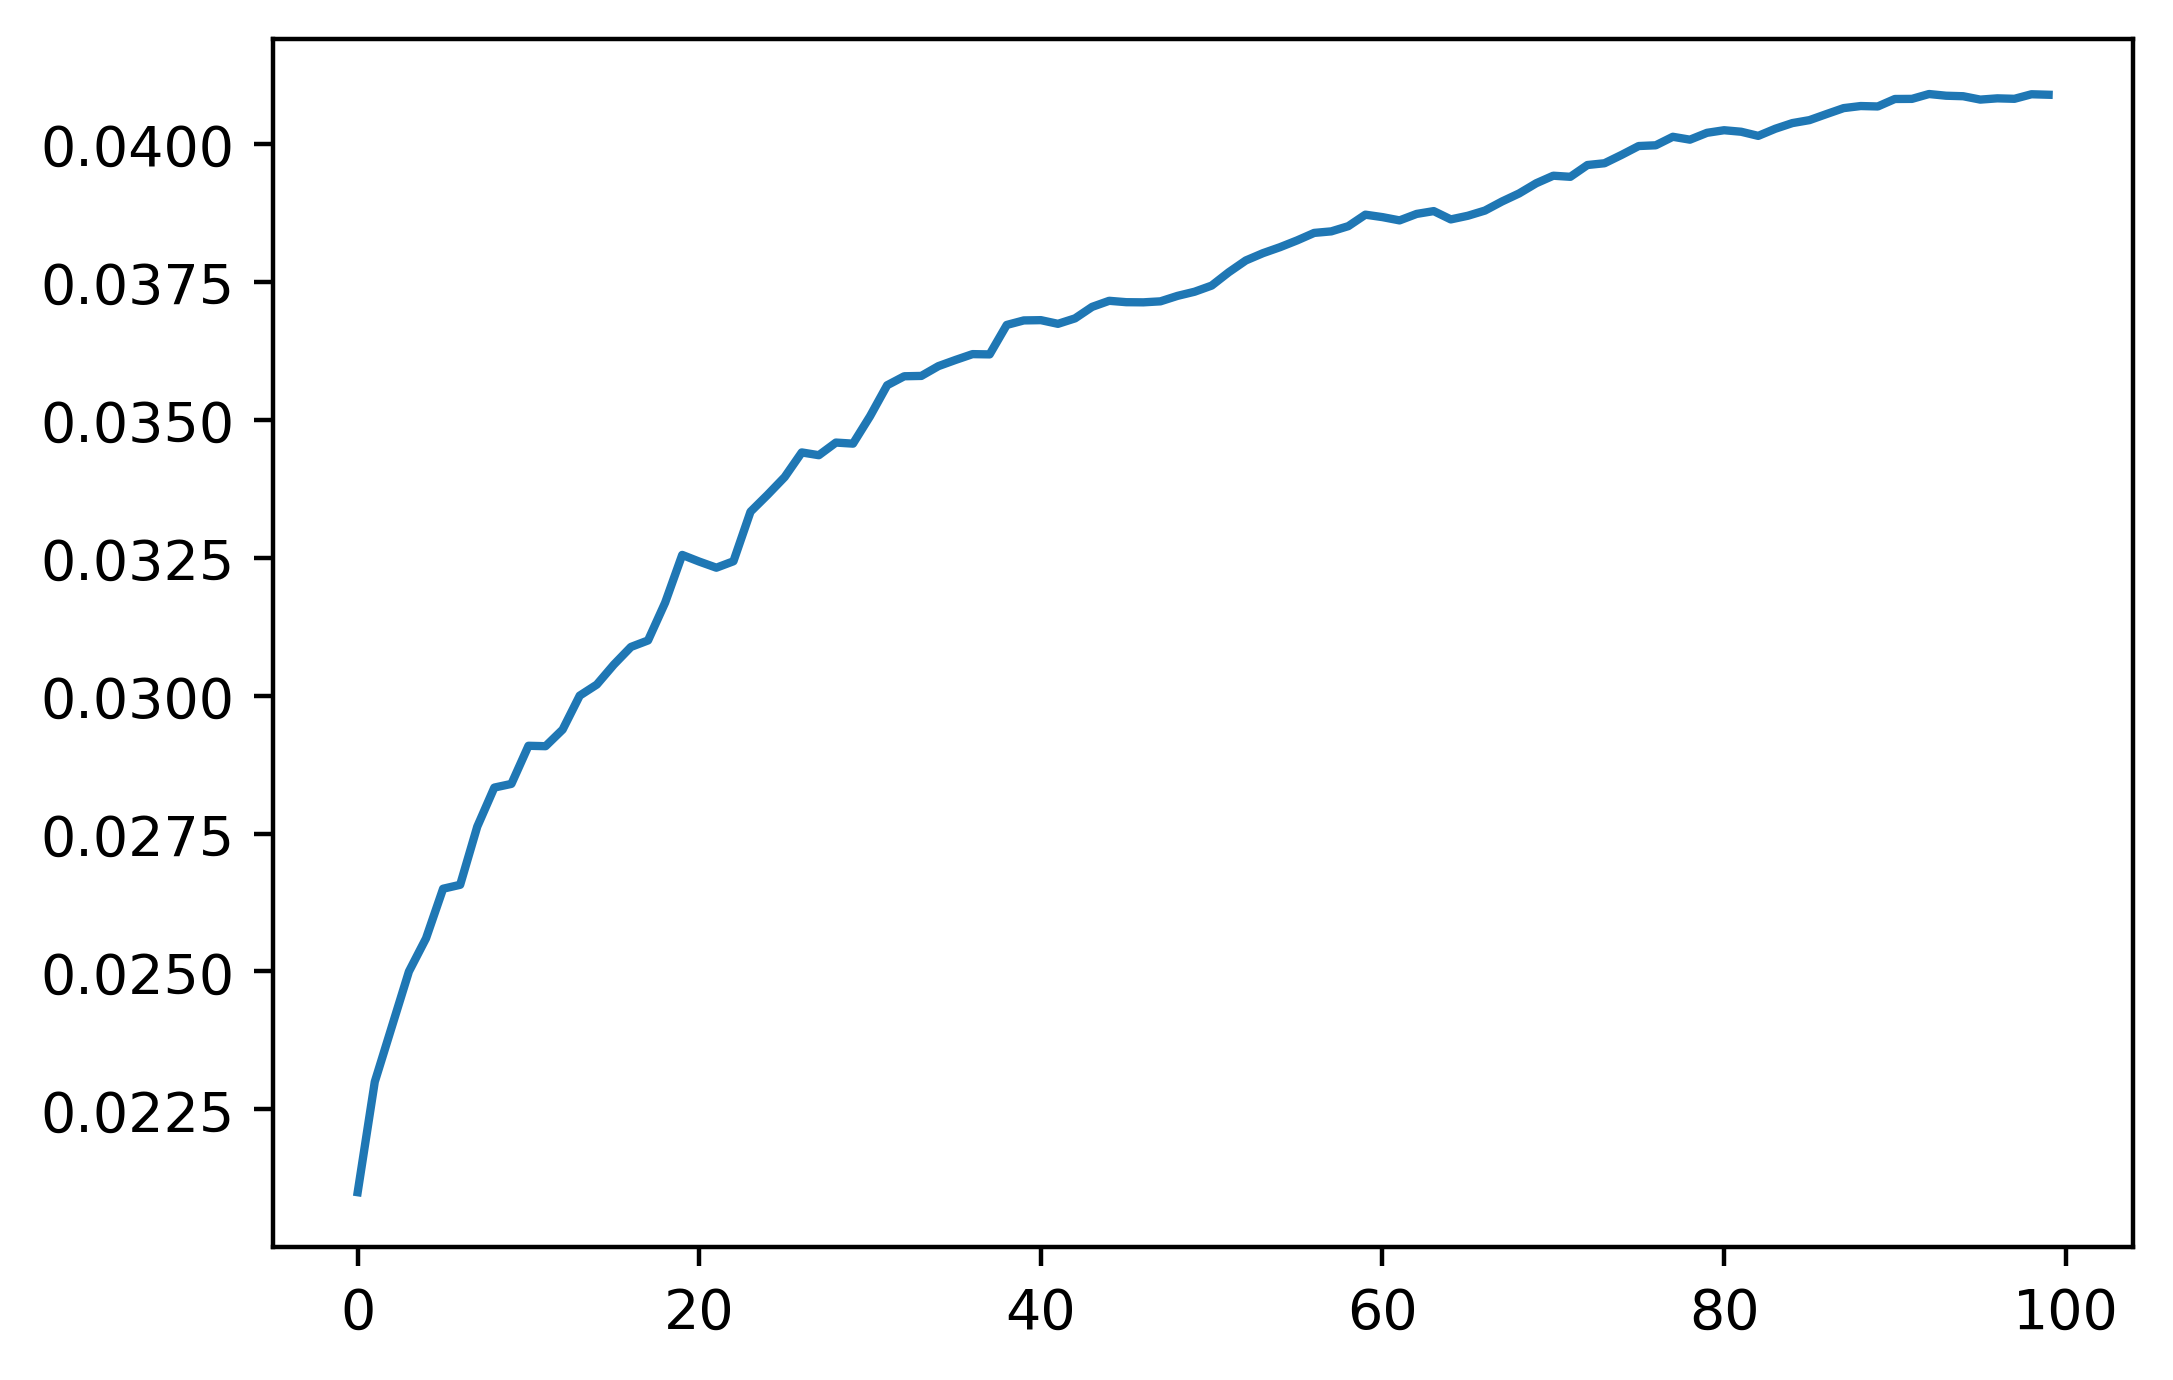

In [5]:
plt.figure(dpi=400)
plt.plot(scores)
